In [27]:
import pickle
import patsy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report, make_scorer, fbeta_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Subset answer_time_series to include only top answerers (Avg 2 answers monthly)

In [10]:
with open('./data/processed/answer_time_series_3years_all.pkl', 'rb') as picklefile:
    answer_time_series_3years_all = pickle.load(picklefile)
with open('./data/processed/question_time_series_3years_all.pkl', 'rb') as picklefile:
    question_time_series_3years_all = pickle.load(picklefile)
with open('./data/processed/comment_time_series_3years_all.pkl', 'rb') as picklefile:
    comment_time_series_3years_all = pickle.load(picklefile)

In [17]:
def setMinAnswer(signupmonth, year_start, year_end):
    if ((signupmonth//100) < year_start):
        return (year_end-year_start+1)*24
    else:
        return (year_end-(signupmonth//100))*24 + (12-(signupmonth%100))*2
def extractTopAnswerer(df_ts, year_start, year_end):
    top_answerer = deepcopy(df_ts)
    top_answerer['min_answer'] = top_answerer.apply(lambda row:setMinAnswer(row[-1], year_start, year_end), axis=1)
    top_answerer_index = top_answerer.iloc[:,:-2].sum(axis=1) > top_answerer.min_answer
    top_answerer = top_answerer[top_answerer_index]
    top_answerer.drop('min_answer', inplace=True, axis=1)
    return top_answerer, top_answerer_index

In [23]:
top_answerer, top_answerer_idx = extractTopAnswerer(answer_time_series_3years_all, 2015, 2017)

In [24]:
top_answerer_question = question_time_series_3years_all[top_answerer_idx]
top_answerer_comment = comment_time_series_3years_all[top_answerer_idx]

In [29]:
with open('./data/processed/top_answerer_3year_all.pkl', 'wb') as picklefile:
    pickle.dump(top_answerer, picklefile)
with open('./data/processed/top_answerer_question.pkl', 'wb') as picklefile:
    pickle.dump(top_answerer_question, picklefile)
with open('./data/processed/top_answerer_comment.pkl', 'wb') as picklefile:
    pickle.dump(top_answerer_comment, picklefile)

### Segment time series into 18 months, ignoring numbers before user signup

In [3]:
with open('./data/processed/top_answerer_3year_all.pkl', 'rb') as picklefile:
    top_answerer_3year_all = pickle.load(picklefile)
with open('./data/processed/top_answerer_question.pkl', 'rb') as picklefile:
    top_answerer_question = pickle.load(picklefile)
with open('./data/processed/top_answerer_comment.pkl', 'rb') as picklefile:
    top_answerer_comment = pickle.load(picklefile)

In [4]:
print (top_answerer_3year_all.shape)
print (top_answerer_question.shape)
print (top_answerer_comment.shape)

(18446, 37)
(18446, 37)
(18446, 37)


In [58]:
def monthsSince2015(signup_month):
    return ((signup_month//100)-2015)*12 + ((signup_month%100)-1)
df = deepcopy(top_answerer_3year_all)
df['cutoff'] = df.apply(lambda x:monthsSince2015(x[36]), axis=1)
keep_index =  df['cutoff']<=0
answers = top_answerer_3year_all[keep_index].iloc[:, 0:18]
answers.columns = ['ans-M', 'ans-M+1', 'ans-M+2', 'ans-M+3',
             'ans-M+4', 'ans-M+5', 'ans-M+6', 'ans-M+7',
             'ans-M+8', 'ans-M+9', 'ans-M+10', 'ans-M+11',
             'ans-M+12', 'ans-M+13','ans-M+14', 'ans-M+15',
             'ans-M+16', 'ans-M+17']

In [57]:
questions = top_answerer_question[keep_index].iloc[:,0:12]
questions.columns = ['qns-M', 'qns-M+1', 'qns-M+2', 'qns-M+3',
             'qns-M+4', 'qns-M+5', 'qns-M+6', 'qns-M+7',
             'qns-M+8', 'qns-M+9', 'qns-M+10', 'qns-M+11']
questions

,qns-M,qns-M+1,qns-M+2,qns-M+3,qns-M+4,qns-M+5,qns-M+6,qns-M+7,qns-M+8,qns-M+9,qns-M+10,qns-M+11
id,,,,,,,,,,,,
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
476,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
905,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
1026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [59]:
joint_data = pd.merge(questions, answers, how='left', left_index=True, right_index=True)

In [60]:
joint_data.head()

,qns-M,qns-M+1,qns-M+2,qns-M+3,qns-M+4,qns-M+5,qns-M+6,qns-M+7,qns-M+8,qns-M+9,...,ans-M+8,ans-M+9,ans-M+10,ans-M+11,ans-M+12,ans-M+13,ans-M+14,ans-M+15,ans-M+16,ans-M+17
id,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.0,12.0,21.0,3.0,0.0,25.0,19.0,9.0,7.0,21.0
267,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,17.0,29.0,15.0,22.0,26.0,19.0,8.0,18.0,22.0,25.0
369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,3.0,1.0,0.0,7.0,3.0,6.0,8.0,27.0,23.0
459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,2.0,0.0,1.0,1.0,0.0,6.0,14.0,5.0
476,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,77.0,63.0,35.0,55.0,60.0,93.0,80.0,57.0,29.0,50.0


In [42]:
comments = top_answerer_comment[keep_index].iloc[:,0:12].values

In [45]:
joint_data = np.concatenate((joint_data, comments), axis=1)

In [48]:
colnames = ['com-M', 'com-M+1', 'com-M+2', 'com-M+3',
             'com-M+4', 'com-M+5', 'com-M+6', 'com-M+7',
             'com-M+8', 'com-M+9', 'com-M+10', 'com-M+11',
             'qns-M', 'qns-M+1', 'qns-M+2', 'qns-M+3',
             'qns-M+4', 'qns-M+5', 'qns-M+6', 'qns-M+7',
             'qns-M+8', 'qns-M+9', 'qns-M+10', 'qns-M+11',
             'ans-M', 'ans-M+1', 'ans-M+2', 'ans-M+3',
             'ans-M+4', 'ans-M+5', 'ans-M+6', 'ans-M+7',
             'ans-M+8', 'ans-M+9', 'ans-M+10', 'ans-M+11',
             'ans-M+12', 'ans-M+13','ans-M+14', 'ans-M+15',
             'ans-M+16', 'ans-M+17']

In [49]:
test = pd.DataFrame(joint_data, columns=colnames)

In [63]:
print(test.shape)
test = pd.concat([test, test], axis=0)
test.shape

(26050, 42)


(52100, 42)

In [64]:
test.head()

,com-M,com-M+1,com-M+2,com-M+3,com-M+4,com-M+5,com-M+6,com-M+7,com-M+8,com-M+9,...,ans-M+8,ans-M+9,ans-M+10,ans-M+11,ans-M+12,ans-M+13,ans-M+14,ans-M+15,ans-M+16,ans-M+17
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.0,8.0,21.0,5.0,6.0,33.0,52.0,21.0,32.0,3.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,104.0,137.0,117.0,217.0,220.0,161.0,108.0,167.0,139.0,148.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,117.0,137.0,59.0,124.0,164.0,109.0,36.0,21.0,9.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,3.0,0.0,0.0,10.0,19.0,1.0,5.0,2.0,0.0
4,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,241.0,366.0,244.0,293.0,203.0,279.0,294.0,240.0,276.0,285.0


In [77]:
# Split data into many rows with 12 months' record, use the last n months to determine if user has churned
def monthsSince2015(signup_month):
    return ((signup_month//100)-2015)*12 + ((signup_month%100)-1)

def build_timeseries(df_answers, df_questions, df_comments, mode='convertEndStatus'):
    df = deepcopy(df_answers)
    df['cutoff'] = df.apply(lambda x:monthsSince2015(x[36]), axis=1)
    keep_index =  df['cutoff']<=0
    answers = df[keep_index].iloc[:, 0:18]
    answer_colnames = ['ans-M', 'ans-M+1', 'ans-M+2', 'ans-M+3',
             'ans-M+4', 'ans-M+5', 'ans-M+6', 'ans-M+7',
             'ans-M+8', 'ans-M+9', 'ans-M+10', 'ans-M+11',
             'ans-M+12', 'ans-M+13','ans-M+14', 'ans-M+15',
             'ans-M+16', 'ans-M+17']
    answers.columns = answer_colnames
    questions = df_questions[keep_index].iloc[:,0:12]
    question_colnames = ['qns-M', 'qns-M+1', 'qns-M+2', 'qns-M+3',
             'qns-M+4', 'qns-M+5', 'qns-M+6', 'qns-M+7',
             'qns-M+8', 'qns-M+9', 'qns-M+10', 'qns-M+11']
    questions.columns = question_colnames
    joint_data = pd.merge(questions, answers, how='left', left_index=True, right_index=True)
    comments = df_comments[keep_index].iloc[:,0:12]
    comment_colnames = ['com-M', 'com-M+1', 'com-M+2', 'com-M+3',
             'com-M+4', 'com-M+5', 'com-M+6', 'com-M+7',
             'com-M+8', 'com-M+9', 'com-M+10', 'com-M+11']
    comments.columns = comment_colnames
    joint_data = pd.merge(comments, joint_data, how='left', left_index=True, right_index=True)
    print ('round 0 - added', joint_data.shape[0], 'rows')
    
    for i in range(1, df_answers.shape[1] - 19):
        keep_index = df['cutoff']<=i
        answers = df[keep_index].iloc[:, i:i+18]
        answers.columns = answer_colnames
        questions = df_questions[keep_index].iloc[:,i:i+12]
        questions.columns = question_colnames
        extra_data = pd.merge(questions, answers, how='left', left_index=True, right_index=True)
        comments = df_comments[keep_index].iloc[:,i:i+12]
        comments.columns = comment_colnames
        extra_data = pd.merge(comments, extra_data, how='left', left_index=True, right_index=True)
        joint_data = pd.concat([joint_data, extra_data], axis=0)
        print ('round', i, '- added', extra_data.shape[0], 'rows')
        
    if (mode == 'convertEndStatus'):
        joint_data['inactive'] = joint_data.apply(lambda x:1 if np.sum(x[-6:])==0 else 0, axis=1)
    elif (mode == 'countLast6moAnswer'):
        joint_data['last6Month'] = joint_data.apply(lambda x:np.sum(x[-6:]), axis=1)
    joint_data.drop(['ans-M+12', 'ans-M+13','ans-M+14', 'ans-M+15', 'ans-M+16', 'ans-M+17'], inplace=True, axis=1)

    return joint_data

In [78]:
%time top_answerer = build_timeseries(top_answerer_3year_all, top_answerer_question, top_answerer_comment, 'convertEndStatus')

round 0 - added 13025 rows
(13025, 42)
(13300, 18)
(13300, 30)
(13300, 12)
(13300, 42)
round 1 - added 13300 rows
(13587, 18)
(13587, 30)
(13587, 12)
(13587, 42)
round 2 - added 13587 rows
(13920, 18)
(13920, 30)
(13920, 12)
(13920, 42)
round 3 - added 13920 rows
(14184, 18)
(14184, 30)
(14184, 12)
(14184, 42)
round 4 - added 14184 rows
(14491, 18)
(14491, 30)
(14491, 12)
(14491, 42)
round 5 - added 14491 rows
(14784, 18)
(14784, 30)
(14784, 12)
(14784, 42)
round 6 - added 14784 rows
(15094, 18)
(15094, 30)
(15094, 12)
(15094, 42)
round 7 - added 15094 rows
(15376, 18)
(15376, 30)
(15376, 12)
(15376, 42)
round 8 - added 15376 rows
(15681, 18)
(15681, 30)
(15681, 12)
(15681, 42)
round 9 - added 15681 rows
(15924, 18)
(15924, 30)
(15924, 12)
(15924, 42)
round 10 - added 15924 rows
(16192, 18)
(16192, 30)
(16192, 12)
(16192, 42)
round 11 - added 16192 rows
(16537, 18)
(16537, 30)
(16537, 12)
(16537, 42)
round 12 - added 16537 rows
(16866, 18)
(16866, 30)
(16866, 12)
(16866, 42)
round 13 -

In [82]:
with open('./data/processed/top_answerer.pkl', 'wb') as picklefile:
    pickle.dump(top_answerer, picklefile)

In [2]:
with open('./data/processed/top_answerer.pkl', 'rb') as picklefile:
    top_answerer = pickle.load(picklefile)

## Merge the user demographic data with answer time series

In [3]:
with open('./data/processed/user_basic_processed.pkl', 'rb') as picklefile:
    user_basic = pickle.load(picklefile)

In [4]:
user_basic.drop(['up_votes', 'down_votes'], axis=1, inplace=True)

In [5]:
top_answerer_basic = pd.merge(user_basic, top_answerer, how='right', left_index=True, right_index=True)

## Formalize X and Y

In [6]:
with open('./data/processed/location_dict.pkl', 'rb') as picklefile:
    location_dict = pickle.load(picklefile)

In [7]:
y = top_answerer_basic['inactive']
X = top_answerer_basic.drop('inactive', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4444, stratify=y)

In [8]:
## Dummify location
with open('./data/processed/location_dict.pkl', 'rb') as picklefile:
    location_dict = pickle.load(picklefile)
    
def map_dummify_Locations(df, location_dict):
    df['location'] = df.location.apply(lambda x:location_dict[x] if x in set(location_dict.keys()) else 'Others')
    location_dummy = patsy.dmatrix('location', data=df, return_type='dataframe')
    df = pd.concat([df, location_dummy], axis = 1)
    df.drop('location', axis=1, inplace=True)
    new_colnames = [item.replace('[','-') for item in list(df.columns)]
    new_colnames = [item.replace(']','') for item in new_colnames]
    df.columns = new_colnames
    df.drop('Intercept', axis=1, inplace=True)
    return df

In [9]:
X_train = map_dummify_Locations(X_train, location_dict)
X_test = map_dummify_Locations(X_test, location_dict)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
with open('./data/processed/X_train.pkl', 'wb') as picklefile:
    pickle.dump(X_train, picklefile)
with open('./data/processed/y_train.pkl', 'wb') as picklefile:
    pickle.dump(y_train, picklefile)
with open('./data/processed/X_test.pkl', 'wb') as picklefile:
    pickle.dump(X_test, picklefile)
with open('./data/processed/y_test.pkl', 'wb') as picklefile:
    pickle.dump(y_test, picklefile)

In [34]:
with open('./data/processed/X_train.pkl', 'rb') as picklefile:
    X_train = pickle.load(picklefile)
with open('./data/processed/y_train.pkl', 'rb') as picklefile:
    y_train = pickle.load(picklefile)
with open('./data/processed/X_test.pkl', 'rb') as picklefile:
    X_test = pickle.load(picklefile)
with open('./data/processed/y_test.pkl', 'rb') as picklefile:
    y_test = pickle.load(picklefile)

## Prepare data for training

In [3]:
# Normalize the data
ssX = StandardScaler()
X_train_norm = ssX.fit_transform(X_train)

In [4]:
np.sum(y_train == 1)/y_train.shape[0]

0.15039449274714467

In [5]:
X_train_resampled, y_train_resampled = RandomUnderSampler(random_state=4444).fit_sample(X_train_norm, y_train.ravel())

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=4444, stratify=y_train_resampled)

In [10]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
output = XGBClassifier().fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


[0]	validation_0-auc:0.830068	validation_0-error:0.225692	validation_1-auc:0.83257	validation_1-error:0.22351
[1]	validation_0-auc:0.841207	validation_0-error:0.223444	validation_1-auc:0.843557	validation_1-error:0.221504
[2]	validation_0-auc:0.843084	validation_0-error:0.225692	validation_1-auc:0.845619	validation_1-error:0.22351
[3]	validation_0-auc:0.844828	validation_0-error:0.225339	validation_1-auc:0.848152	validation_1-error:0.223659
[4]	validation_0-auc:0.846048	validation_0-error:0.224837	validation_1-auc:0.849632	validation_1-error:0.223213
[5]	validation_0-auc:0.846768	validation_0-error:0.219989	validation_1-auc:0.850317	validation_1-error:0.218309
[6]	validation_0-auc:0.847835	validation_0-error:0.219654	validation_1-auc:0.851308	validation_1-error:0.2192
[7]	validation_0-auc:0.848352	validation_0-error:0.219506	validation_1-auc:0.851736	validation_1-error:0.2192
[8]	validation_0-auc:0.849407	validation_0-error:0.218651	validation_1-auc:0.853068	validation_1-error:0.217789

[73]	validation_0-auc:0.864428	validation_0-error:0.207171	validation_1-auc:0.865922	validation_1-error:0.20642
[74]	validation_0-auc:0.864504	validation_0-error:0.206911	validation_1-auc:0.865977	validation_1-error:0.206123
[75]	validation_0-auc:0.86458	validation_0-error:0.206948	validation_1-auc:0.865998	validation_1-error:0.206494
[76]	validation_0-auc:0.864675	validation_0-error:0.206948	validation_1-auc:0.866025	validation_1-error:0.20642
[77]	validation_0-auc:0.864742	validation_0-error:0.207171	validation_1-auc:0.86605	validation_1-error:0.206569
[78]	validation_0-auc:0.864801	validation_0-error:0.207115	validation_1-auc:0.866067	validation_1-error:0.206494
[79]	validation_0-auc:0.864906	validation_0-error:0.207115	validation_1-auc:0.866151	validation_1-error:0.206494
[80]	validation_0-auc:0.864968	validation_0-error:0.207208	validation_1-auc:0.86622	validation_1-error:0.206792
[81]	validation_0-auc:0.865111	validation_0-error:0.207134	validation_1-auc:0.86627	validation_1-erro

In [30]:
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=10)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy: {}".format(accuracy_score(y, dtrain_predictions)) )
    print ("AUC Score (Train): {}".format(roc_auc_score(y, dtrain_predprob)))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[0]	train-auc:0.845464+0.000914012	test-auc:0.843691+0.00216334
[10]	train-auc:0.85974+0.000641755	test-auc:0.855898+0.00175531
[20]	train-auc:0.863787+0.000556428	test-auc:0.858545+0.00168995
[30]	train-auc:0.867624+0.000612779	test-auc:0.860432+0.00202061
[40]	train-auc:0.870739+0.000469445	test-auc:0.861579+0.00197847
[50]	train-auc:0.873338+0.000509116	test-auc:0.862436+0.00201339
[60]	train-auc:0.875556+0.000539342	test-auc:0.862947+0.0021516
[70]	train-auc:0.877455+0.000564685	test-auc:0.863314+0.00228641
[80]	train-auc:0.879116+0.000525859	test-auc:0.863522+0.00220905
[90]	train-auc:0.880641+0.000564987	test-auc:0.863654+0.0021465
[100]	train-auc:0.882011+0.000617967	test-auc:0.86382+0.00210436
[110]	train-auc:0.883394+0.000616824	test-auc:0.863965+0.00215702
[120]	train-auc:0.884621+0.000579894	test-auc:0.864018+0.00213693
[130]	train-auc:0.885901+0.000612098	test-auc:0.864147+0.00224293
[140]	train-auc:0.887112+0.000702892	test-auc:0.864145+0.00211288
[150]	train-auc:0.888356+

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy: 0.8240399476875521
AUC Score (Train): 0.8997068615533544


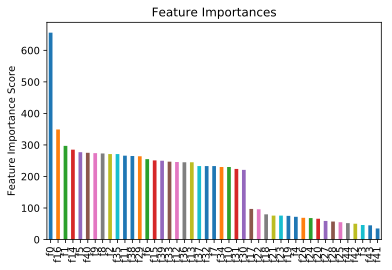

In [31]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train_resampled, y_train_resampled)


In [38]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=360, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train_resampled, y_train_resampled)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86373, std: 0.00151, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86378, std: 0.00169, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.86359, std: 0.00147, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.86447, std: 0.00121, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.86426, std: 0.00118, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.86429, std: 0.00116, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.86406, std: 0.00114, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.86345, std: 0.00092, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.86337, std: 0.00155, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.86411, std: 0.00095, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.86309, std: 0.00141, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.86294, std: 0.00092, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [40]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,2]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=360, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train_resampled, y_train_resampled)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86373, std: 0.00151, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86378, std: 0.00169, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.86359, std: 0.00147, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.86447, std: 0.00121, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.86426, std: 0.00118, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.86429, std: 0.00116, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.86406, std: 0.00114, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.86345, std: 0.00092, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.86337, std: 0.00155, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.86411, std: 0.00095, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.86309, std: 0.00141, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.86294, std: 0.00092, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [41]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=360, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train_resampled, y_train_resampled)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86447, std: 0.00121, params: {'gamma': 0.0},
  mean: 0.86459, std: 0.00101, params: {'gamma': 0.1},
  mean: 0.86443, std: 0.00146, params: {'gamma': 0.2},
  mean: 0.86456, std: 0.00130, params: {'gamma': 0.3},
  mean: 0.86466, std: 0.00140, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.8646643741794632)

[0]	train-auc:0.845464+0.000914012	test-auc:0.843691+0.00216334
[10]	train-auc:0.85974+0.000641755	test-auc:0.855898+0.00175531
[20]	train-auc:0.863787+0.000556428	test-auc:0.858545+0.00168995
[30]	train-auc:0.867624+0.000612779	test-auc:0.860432+0.00202061
[40]	train-auc:0.870739+0.00046977	test-auc:0.861579+0.0019784
[50]	train-auc:0.873332+0.000514439	test-auc:0.862434+0.0020112
[60]	train-auc:0.875552+0.000539133	test-auc:0.862949+0.00218207
[70]	train-auc:0.877514+0.000469979	test-auc:0.863283+0.00229373
[80]	train-auc:0.879142+0.000556959	test-auc:0.863508+0.00226452
[90]	train-auc:0.88052+0.000494348	test-auc:0.863719+0.00229106
[100]	train-auc:0.881905+0.000575667	test-auc:0.863853+0.0022
[110]	train-auc:0.8833+0.000570743	test-auc:0.863949+0.00225462
[120]	train-auc:0.884533+0.000521214	test-auc:0.864048+0.00229393
[130]	train-auc:0.885826+0.000607306	test-auc:0.864132+0.00233777
[140]	train-auc:0.887129+0.000638792	test-auc:0.864141+0.00226343
[150]	train-auc:0.888399+0.00066

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy: 0.8244560694328855
AUC Score (Train): 0.9001732183537245


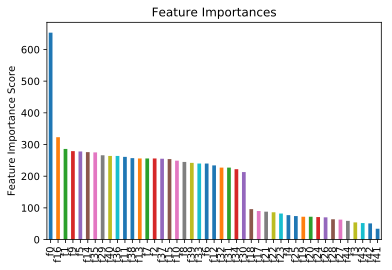

In [43]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, X_train_resampled, y_train_resampled)

In [44]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=360, max_depth=5,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train_resampled, y_train_resampled)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86358, std: 0.00130, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.86386, std: 0.00159, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.86429, std: 0.00126, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.86463, std: 0.00155, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.86366, std: 0.00088, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.86360, std: 0.00165, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.86452, std: 0.00124, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.86493, std: 0.00153, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.86313, std: 0.00127, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.86406, std: 0.00101, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.86466, std: 0.00140, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.86475, std: 0.00107, params: {'colsample_bytree': 0.8, 'subsample'

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(65,80,5)],
 'colsample_bytree':[i/100.0 for i in range(85,199,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=360, max_depth=5,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train_resampled, y_train_resampled)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_